In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Прогноз по дням 

In [21]:
df1 = pd.read_csv('orders.csv', decimal=';')
df2 = pd.read_csv('partners_delays.csv',decimal=';')

In [22]:
df1['date_orders'] = pd.to_datetime(df1['date'].str[:10])

In [23]:
df1

,delivery_area_id,date,orders_cnt,date_orders
0,0,2021-04-01 10:00:00,9,2021-04-01
1,0,2021-04-01 11:00:00,1,2021-04-01
2,0,2021-04-01 13:00:00,1,2021-04-01
3,0,2021-04-01 14:00:00,1,2021-04-01
4,0,2021-04-01 15:00:00,2,2021-04-01
...,...,...,...,...
884851,592,2021-11-30 16:00:00,6,2021-11-30
884852,592,2021-11-30 17:00:00,3,2021-11-30
884853,592,2021-11-30 18:00:00,2,2021-11-30
884854,592,2021-11-30 19:00:00,4,2021-11-30


In [34]:

df_sum = df1.groupby(['date_orders'])['orders_cnt'].sum()

In [35]:
df_sum = pd.DataFrame(data= df_sum)

In [36]:
def create_features(data):
    """
    Create time series features based on time series index.
    """
    data = data.copy()
    
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofyear'] = data.index.dayofyear
    data['dayofmonth'] = data.index.day
    data['weekofyear'] = data.index.isocalendar().week.astype(int)
    
    data['Percent of orders'] = data.orders_cnt/data.orders_cnt.sum()
    data['MA_7_orders'] = data.orders_cnt.rolling(window=7).mean()
    data['MA_30_orders'] = data.orders_cnt.rolling(window=30).mean()
    return data

df_sum = create_features(df_sum)
df_sum = df_sum.fillna(0)

In [37]:
df_sum

,orders_cnt,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Percent of orders,MA_7_orders,MA_30_orders
date_orders,,,,,,,,,,,
2021-04-01,1280,3,2,4,2021,91,1,13,0.000382,0.000000,0.000000
2021-04-02,1192,4,2,4,2021,92,2,13,0.000355,0.000000,0.000000
2021-04-03,1269,5,2,4,2021,93,3,13,0.000378,0.000000,0.000000
2021-04-04,1261,6,2,4,2021,94,4,13,0.000376,0.000000,0.000000
2021-04-05,1928,0,2,4,2021,95,5,14,0.000575,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,34853,4,4,11,2021,330,26,47,0.010393,35473.428571,31937.900000
2021-11-27,40550,5,4,11,2021,331,27,47,0.012091,35463.571429,32297.166667
2021-11-28,40440,6,4,11,2021,332,28,47,0.012059,35601.428571,32697.066667


In [38]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime,date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler


import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings(action='ignore')

import lightgbm as ltb
from lightgbm import LGBMRegressor
from lightgbm import plot_importance,plot_metric
import torch
from torch import nn

In [39]:
def tts(data):
    data_train = data[:-14]
    data_test = data[-14:]
    train = data_train.iloc[:-7]
    target = data_train.iloc[7:]['orders_cnt']
    test = data_test.iloc[:-7]
    test_target = data_test.iloc[7:]['orders_cnt']
    print('Train:{}\tTarget:{}\tTest:{}\tTest_target:{}'.format(
        train.shape,target.shape,test.shape,test_target.shape))
    return train,target,test,test_target

In [40]:
df_sum_train,df_sum_target,df_sum_test,df_sum_test_target = tts(df_sum)

Train:(223, 11)	Target:(223,)	Test:(7, 11)	Test_target:(7,)


In [41]:
kf = KFold(n_splits=5,shuffle=True,random_state=0)
def fit_model(train,target):
    lgb_models = []
    fold = 1
    for (train_idx,valid_idx) in kf.split(train,target):
        print(f'Fold:{fold}')
        x_train, x_valid = train.values[train_idx], train.values[valid_idx]
        y_train, y_valid = target.values[train_idx], target.values[valid_idx]
        model = LGBMRegressor(n_estimators=5000,n_jobs=-1,subsample=0.7,subsample_for_bin=512,
                             objective='regression',device='cpu',reg_lambda=0.01,learning_rate=0.05)
        model.fit(x_train,y_train,eval_set=[(x_valid,y_valid)],eval_metric=['mape'],verbose=100,
                  early_stopping_rounds=300
                  )
        lgb_models.append(model)
        fold += 1
    return lgb_models

In [42]:
print('-----------DF_SUM--------------')
df_sum_models = fit_model(df_sum_train,df_sum_target)

-----------DF_SUM--------------
Fold:1
[100]	valid_0's mape: 0.0892742	valid_0's l2: 2.55719e+06
[200]	valid_0's mape: 0.0855559	valid_0's l2: 2.32376e+06
[300]	valid_0's mape: 0.0832793	valid_0's l2: 2.13628e+06
[400]	valid_0's mape: 0.0817755	valid_0's l2: 2.01354e+06
[500]	valid_0's mape: 0.0787502	valid_0's l2: 1.91369e+06
[600]	valid_0's mape: 0.0770437	valid_0's l2: 1.85872e+06
[700]	valid_0's mape: 0.0749509	valid_0's l2: 1.81361e+06
[800]	valid_0's mape: 0.0722558	valid_0's l2: 1.76767e+06
[900]	valid_0's mape: 0.0707172	valid_0's l2: 1.72832e+06
[1000]	valid_0's mape: 0.0692989	valid_0's l2: 1.71427e+06
[1100]	valid_0's mape: 0.068326	valid_0's l2: 1.69225e+06
[1200]	valid_0's mape: 0.0679163	valid_0's l2: 1.68244e+06
[1300]	valid_0's mape: 0.0686004	valid_0's l2: 1.66921e+06
[1400]	valid_0's mape: 0.0688923	valid_0's l2: 1.66386e+06
Fold:2
[100]	valid_0's mape: 0.0973445	valid_0's l2: 882430
[200]	valid_0's mape: 0.09388	valid_0's l2: 780187
[300]	valid_0's mape: 0.0932158	va

In [43]:
def feature_importance(model,train):
    plt.figure(figsize=(15,10))
    feature = pd.Series(model.feature_importances_,index=train.columns)
    sort_feature = feature.sort_values(ascending=False)
    return sns.barplot(x=sort_feature,y=sort_feature.index)

<AxesSubplot: >

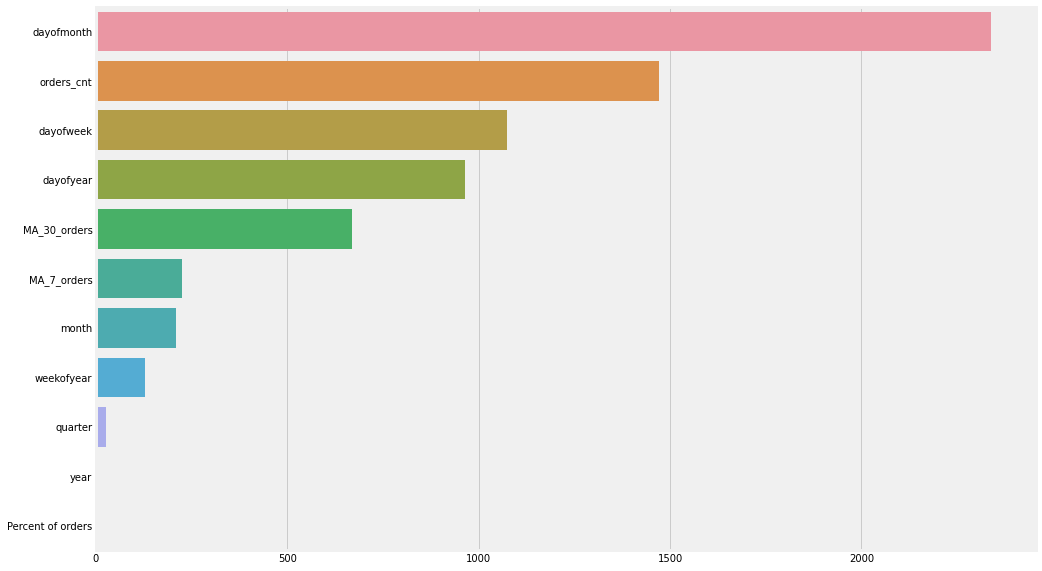

In [44]:
feature_importance(df_sum_models[0],df_sum_train)

In [45]:
def ensemble(lgb_models,test):
    result = []
    for model in lgb_models:
        pred = model.predict(test)
        result.append(pred)
    pred_deaths = np.mean(result,axis=0)
    return pred_deaths

In [46]:
df_sum.dtypes

orders_cnt             int64
dayofweek              int64
quarter                int64
month                  int64
year                   int64
dayofyear              int64
dayofmonth             int64
weekofyear             int64
Percent of orders    float64
MA_7_orders          float64
MA_30_orders         float64
dtype: object

In [47]:
df_sum_models = df_sum_models[3]
df_sum_models_pred_orders = df_sum_models.predict(df_sum_test)

In [48]:
df_sum_result = pd.DataFrame({'date':df_sum_test_target.index,'new_orders':df_sum_test_target.values,
                           'pred_new_orders':df_sum_models_pred_orders})
df_sum_result

,date,new_orders,pred_new_orders
0,2021-11-24,34571,26862.154889
1,2021-11-25,34789,28822.493191
2,2021-11-26,34853,28822.493191
3,2021-11-27,40550,29538.743146
4,2021-11-28,40440,30204.512608
5,2021-11-29,33392,26668.635455
6,2021-11-30,36311,27314.070558


# Часовое моделирование 

In [ ]:
df1 = pd.read_csv('orders.csv', decimal=';')
df2 = pd.read_csv('partners_delays.csv',decimal=';')

In [ ]:
df1['date_orders'] = pd.to_datetime(df1['date'].str[:10])

In [24]:
df1['date'] = pd.to_datetime(df1['date'],format='%Y-%m-%d %H:%M:%S')
df2['dttm'] = pd.to_datetime(df2['dttm'],format='%Y-%m-%d %H:%M:%S')

In [25]:
df1.set_index(df1.date, inplace=True)

In [26]:
df1 = df1.drop(['date','delivery_area_id'], axis=1)

In [27]:
df1_h = df1.groupby(['date'])['orders_cnt'].sum()

In [28]:
df1_h = pd.DataFrame(data= df1_h)

In [29]:
df1_h

,orders_cnt
date,
2021-04-01 07:00:00,1
2021-04-01 08:00:00,2
2021-04-01 09:00:00,7
2021-04-01 10:00:00,200
2021-04-01 11:00:00,110
...,...
2021-11-30 18:00:00,3578
2021-11-30 19:00:00,3755
2021-11-30 20:00:00,3460


In [30]:
def create_features(df1):
    """
    Create time series features based on time series index.
    """
    df1 = df1.copy()
    df1['hour'] = df1.index.hour
    df1['dayofweek'] = df1.index.dayofweek
    df1['quarter'] = df1.index.quarter
    df1['month'] = df1.index.month
    df1['year'] = df1.index.year
    df1['dayofyear'] = df1.index.dayofyear
    df1['dayofmonth'] = df1.index.day
    df1['weekofyear'] = df1.index.isocalendar().week
    return df1

df1_h = create_features(df1_h)

In [31]:
df1_h.set_index(df1_h.hour,inplace=True)

In [32]:
df1_h = df1_h.drop(['hour'], axis=1)

In [33]:
    df1_h['Until 12'] = df1_h.index < 12
    df1_h['Before 12'] = df1_h.index >= 12
    df1_h['Every 6'] = (df1_h.index % 6 == 0)
    df1_h['Every 3'] = (df1_h.index % 3 == 0)

In [36]:
df1_h = df1_h.astype(int)

In [39]:
df1_h

,orders_cnt,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Until 12,Before 12,Every 6,Every 3
hour,,,,,,,,,,,,
7,1,3,2,4,2021,91,1,13,1,0,0,0
8,2,3,2,4,2021,91,1,13,1,0,0,0
9,7,3,2,4,2021,91,1,13,1,0,0,1
10,200,3,2,4,2021,91,1,13,1,0,0,0
11,110,3,2,4,2021,91,1,13,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18,3578,1,4,11,2021,334,30,48,0,1,1,1
19,3755,1,4,11,2021,334,30,48,0,1,0,0
20,3460,1,4,11,2021,334,30,48,0,1,0,0


In [136]:
def tts(data):
    data_train = data.loc[(data['dayofyear']<=320)]
    data_test = data.loc[(data['dayofyear']>=320)]
    train = data_train.loc[(data_train['dayofyear']<=313)]
    target = data_train.loc[(data_train['dayofyear']>=98)]['orders_cnt']
    test = data_test.loc[data_test['dayofyear']<=327]
    test_target = data_test.loc[data_test['dayofyear']>=327]['orders_cnt']
    print('Train:{}\tTarget:{}\tTest:{}\tTest_target:{}'.format(
        train.shape,target.shape,test.shape,test_target.shape))
    return train,target,test,test_target

In [137]:
h_train,h_target,h_test,h_test_target = tts(df1_h)

Train:(3353, 12)	Target:(3349,)	Test:(121, 12)	Test_target:(120,)


### основная пробелма с развером тест и трайн выборки 
* я тут высчитывал окно в 2 недели по столбцу dayofyear с окном 7 дней и 14 
* но тут крч есть проблемка с временем заказов, так как в один из дней заказы могли быть с 7 утра и до 22 вечера, а в другой с 8 до 22 
* если кто то придумает другой способ было бы збс как посчитать по часам

In [148]:
kf = KFold(n_splits=5,shuffle=True,random_state=0)
def fit_model(train,target):
    lgb_models = []
    fold = 1
    for (train_idx,valid_idx) in kf.split(train,target):
        print(f'Fold:{fold}')
        x_train, x_valid = train.values[train_idx], train.values[valid_idx]
        y_train, y_valid = target.values[train_idx], target.values[valid_idx]
        model = LGBMRegressor(n_estimators=5000,n_jobs=-1,subsample=0.7,subsample_for_bin=512,
                             objective='regression',device='cpu',reg_lambda=0.01,learning_rate=0.05)
        model.fit(x_train,y_train,eval_set=[(x_valid,y_valid)],eval_metric=['mape'],verbose=100,
                  early_stopping_rounds=300
                  )
        lgb_models.append(model)
        fold += 1
    return lgb_models

In [149]:
print('-----------H_MODELS--------------')
h_models = fit_model(h_train,h_target)

-----------ITA--------------


ValueError: Found input variables with inconsistent numbers of samples: [3353, 3349]

# Обычный анализ

In [ ]:
df1 = pd.read_csv('orders.csv', decimal=';')
df2 = pd.read_csv('partners_delays.csv',decimal=';')

In [ ]:
df1['date_orders'] = pd.to_datetime(df1['date'].str[:10])

In [24]:
df1['date'] = pd.to_datetime(df1['date'],format='%Y-%m-%d %H:%M:%S')
df2['dttm'] = pd.to_datetime(df2['dttm'],format='%Y-%m-%d %H:%M:%S')

In [ ]:
df1.set_index(df1.date, inplace=True)

In [69]:
def create_features(df1):
    """
    Create time series features based on time series index.
    """
    df1 = df1.copy()
    df1['hour'] = df1.index.hour
    df1['dayofweek'] = df1.index.dayofweek
    df1['quarter'] = df1.index.quarter
    df1['month'] = df1.index.month
    df1['year'] = df1.index.year
    df1['dayofyear'] = df1.index.dayofyear
    df1['dayofmonth'] = df1.index.day
    df1['weekofyear'] = df1.index.isocalendar().week
    df1['DayOfWeek'] = df1.index.day_name()
    df1['Percent of orders'] = df1.orders_cnt/df1.orders_cnt.sum()
    df1['MA_7_orders'] = df1.orders_cnt.rolling(window=7).mean()
    df1['MA_30_orders'] = df1.orders_cnt.rolling(window=30).mean()
    return df1

df1 = create_features(df1)

In [59]:
df1.set_index(df1.date_orders, inplace=True)

In [56]:
df1 = df1.drop(['date_orders'], axis=1)

In [70]:
df1 = df1.fillna(0)

In [71]:
df1

,orders_cnt,date_orders,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,DayOfWeek,Percent of orders,MA_7_orders,MA_30_orders
date,,,,,,,,,,,,,,
2021-04-01 10:00:00,9,2021-04-01,10,3,2,4,2021,91,1,13,Thursday,2.683653e-06,0.000000,0.000000
2021-04-01 11:00:00,1,2021-04-01,11,3,2,4,2021,91,1,13,Thursday,2.981836e-07,0.000000,0.000000
2021-04-01 13:00:00,1,2021-04-01,13,3,2,4,2021,91,1,13,Thursday,2.981836e-07,0.000000,0.000000
2021-04-01 14:00:00,1,2021-04-01,14,3,2,4,2021,91,1,13,Thursday,2.981836e-07,0.000000,0.000000
2021-04-01 15:00:00,2,2021-04-01,15,3,2,4,2021,91,1,13,Thursday,5.963673e-07,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 16:00:00,6,2021-11-30,16,1,4,11,2021,334,30,48,Tuesday,1.789102e-06,5.714286,5.200000
2021-11-30 17:00:00,3,2021-11-30,17,1,4,11,2021,334,30,48,Tuesday,8.945509e-07,4.714286,5.166667
2021-11-30 18:00:00,2,2021-11-30,18,1,4,11,2021,334,30,48,Tuesday,5.963673e-07,3.857143,5.066667


In [66]:
df1.iloc[7:]

,orders_cnt,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,DayOfWeek,Percent of orders,MA_7_orders,MA_30_orders
date_orders,,,,,,,,,,,,,
2021-04-01,2,19,3,2,4,2021,91,1,13,Thursday,5.963673e-07,1.714286,0.000000
2021-04-01,2,20,3,2,4,2021,91,1,13,Thursday,5.963673e-07,1.857143,0.000000
2021-04-01,1,21,3,2,4,2021,91,1,13,Thursday,2.981836e-07,1.857143,0.000000
2021-04-02,3,10,4,2,4,2021,92,2,13,Friday,8.945509e-07,2.142857,0.000000
2021-04-02,1,11,4,2,4,2021,92,2,13,Friday,2.981836e-07,2.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,6,16,1,4,11,2021,334,30,48,Tuesday,1.789102e-06,5.714286,5.200000
2021-11-30,3,17,1,4,11,2021,334,30,48,Tuesday,8.945509e-07,4.714286,5.166667
2021-11-30,2,18,1,4,11,2021,334,30,48,Tuesday,5.963673e-07,3.857143,5.066667


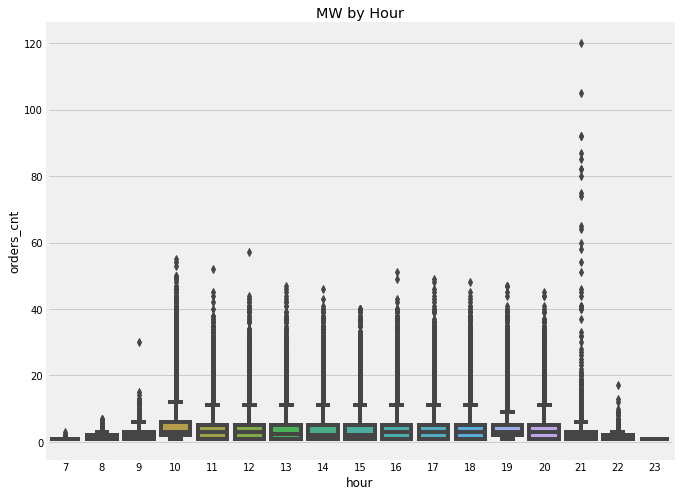

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df1, x='hour', y='orders_cnt')
ax.set_title('MW by Hour')
plt.show()

In [13]:
df1

,orders_cnt,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,DayOfWeek,Percent of orders
date,,,,,,,,,,,
2021-04-01 10:00:00,9,10,3,2,4,2021,91,1,13,Thursday,2.683653e-06
2021-04-01 11:00:00,1,11,3,2,4,2021,91,1,13,Thursday,2.981836e-07
2021-04-01 13:00:00,1,13,3,2,4,2021,91,1,13,Thursday,2.981836e-07
2021-04-01 14:00:00,1,14,3,2,4,2021,91,1,13,Thursday,2.981836e-07
2021-04-01 15:00:00,2,15,3,2,4,2021,91,1,13,Thursday,5.963673e-07
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 16:00:00,6,16,1,4,11,2021,334,30,48,Tuesday,1.789102e-06
2021-11-30 17:00:00,3,17,1,4,11,2021,334,30,48,Tuesday,8.945509e-07
2021-11-30 18:00:00,2,18,1,4,11,2021,334,30,48,Tuesday,5.963673e-07


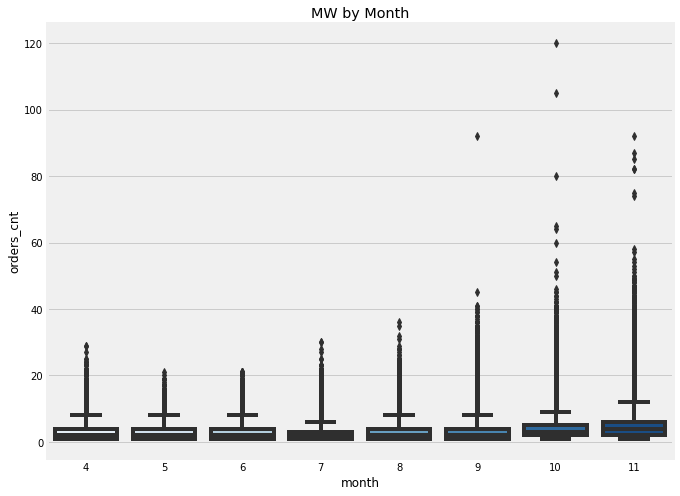

In [63]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df1, x='month', y='orders_cnt', palette='Blues')
ax.set_title('MW by Month')
plt.show()

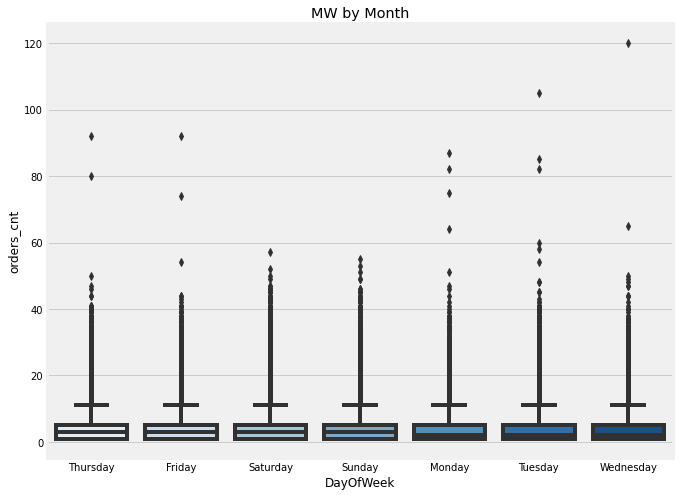

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df1, x='DayOfWeek', y='orders_cnt', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [68]:
df1.groupby(['hour']).sum()

/var/folders/02/g50s5v214l3859l53xfk9xzr0000gn/T/ipykernel_4529/2700130030.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1.groupby(['hour']).sum()


,orders_cnt,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
hour,,,,,,,,
7,108,282,192,459,194016,12433,1524,1777
8,3498,7518,7549,20110,5020164,573576,39603,81930
9,30756,43579,48317,129270,29072085,3719237,234742,531259
10,362565,229658,249829,664568,153226157,19082009,1230341,2725686
11,272829,223432,243365,648082,148005914,18625116,1193010,2660198
12,273107,222271,242067,644651,147292501,18522177,1183486,2645507
13,269195,221631,241367,642864,146773104,18473189,1180698,2638490
14,264873,220234,240735,641329,146419429,18428910,1177622,2632289
15,266061,220304,241808,644275,146900427,18516991,1183357,2644964


In [87]:
df1.groupby(['month']).sum()

/var/folders/02/g50s5v214l3859l53xfk9xzr0000gn/T/ipykernel_4529/145907901.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1.groupby(['month']).sum()


,orders_cnt,hour,dayofweek,quarter,year,dayofyear,dayofmonth,weekofyear
month,,,,,,,,
4,65819,306845,61163,40094,40514987,2127622,323392,303800
5,75968,368494,74088,48338,48845549,3315514,415234,473419
6,145416,728836,138020,95734,96739207,8115679,887762,1160180
7,280568,1693551,345787,333300,224533100,21991927,1882827,3139920
8,420332,2209916,429949,434868,292956076,33118885,2388213,4731972
9,596768,2477606,486528,487164,328186148,42009675,2549391,6001473
10,779708,2793573,590572,731936,369810664,52919844,2965212,7554032
11,989059,2924069,546876,765380,386708245,61150720,2981840,8739697


In [69]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(df1['hour'], df1['orders_cnt'], color ='maroon',
        width = 0.4)
 
plt.xlabel("Courses offered")
plt.ylabel("No. of students enrolled")
plt.title("Students enrolled in different courses")
plt.show()

KeyboardInterrupt: 

In [78]:
dow = df1.loc[(df1['DayOfWeek']=='Sunday')]

In [79]:
dow.groupby(['hour']).sum()

/var/folders/02/g50s5v214l3859l53xfk9xzr0000gn/T/ipykernel_4529/1330809844.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dow.groupby(['hour']).sum()


,orders_cnt,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
hour,,,,,,,,
7,9,54,18,43,18189,1140,119,159
8,444,1860,926,2468,626510,70293,4928,9909
9,4443,12336,6921,18491,4155176,533051,34579,75269
10,55122,66480,36645,97302,22392680,2797190,182861,394850
11,46091,65982,36682,97479,22224937,2804634,182146,395949
12,46810,66000,36630,97308,22231000,2799267,182114,395181
13,46085,66138,36783,97700,22277483,2810851,182463,396826
14,44935,65280,36254,96358,21988480,2772300,180273,391380
15,44998,65376,36377,96696,22020816,2782442,180599,392822


In [81]:
dow_sat = df1.loc[(df1['DayOfWeek']=='Saturday')]

In [83]:
dow_sat.groupby(['hour']).sum().iloc[:,:1]

/var/folders/02/g50s5v214l3859l53xfk9xzr0000gn/T/ipykernel_4529/2907702380.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dow_sat.groupby(['hour']).sum().iloc[:,:1]


,orders_cnt
hour,
7,17
8,556
9,4909
10,59263
11,45921
12,45179
13,44634
14,42677
15,42003


In [84]:
dow_fr = df1.loc[(df1['DayOfWeek']=='Friday')]

In [85]:
dow_fr.groupby(['hour']).sum().iloc[:,:1]

/var/folders/02/g50s5v214l3859l53xfk9xzr0000gn/T/ipykernel_4529/1149989609.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dow_fr.groupby(['hour']).sum().iloc[:,:1]


,orders_cnt
hour,
7,21
8,542
9,4381
10,51486
11,37683
12,37383
13,36680
14,36413
15,36350


In [88]:
df1.groupby(['DayOfWeek']).sum()

,orders_cnt,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
DayOfWeek,,,,,,,,,
Friday,469387,1917906,502420,419196,1108919,253847705,31798232,1982521,4524661
Monday,452568,1921999,0,417989,1116540,253789096,32073746,2020413,4635782
Saturday,513263,1946626,641495,428108,1133704,259292279,32619656,2134122,4623294
Sunday,530068,1979451,781212,433657,1152136,263138242,33146987,2158407,4679483
Thursday,467863,1906066,374259,411362,1097060,252125813,31490074,2006086,4498582
Tuesday,469606,1946144,127245,423230,1131473,257162145,32598729,2142722,4693317
Wednesday,450883,1884698,246352,403272,1081878,248938696,31022442,1949600,4449374


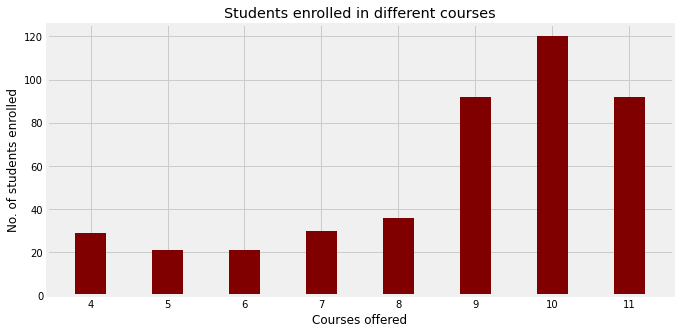

In [86]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(df1['month'], df1['orders_cnt'], color ='maroon',
        width = 0.4)
 
plt.xlabel("Courses offered")
plt.ylabel("No. of students enrolled")
plt.title("Students enrolled in different courses")
plt.show()

In [4]:
df2

,delivery_area_id,dttm,partners_cnt,delay_rate
0,0,2021-04-01 09:00:00,3.0,0.0
1,0,2021-04-01 10:00:00,4.0,0.1111111111111111
2,0,2021-04-01 11:00:00,4.0,0.0
3,0,2021-04-01 12:00:00,4.0,0.0
4,0,2021-04-01 13:00:00,1.0,0.0
...,...,...,...,...
1247466,592,2021-11-30 17:00:00,2.0,0.0
1247467,592,2021-11-30 18:00:00,2.0,0.0
1247468,592,2021-11-30 19:00:00,2.0,0.0
1247469,592,2021-11-30 20:00:00,2.0,0.0
